In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from helperClasses.tennis_ball_detection_pytorch import BallDetectionPytorch
import pyzed.sl as sl
import cv2
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
svo_path ="..\data\HD1080_SN35520970_11-03-24.svo"

In [3]:
ballDetection = BallDetectionPytorch(svo_path)

## Hintergrund berechnen
Um den statischen Hintergrund des Videos zu berechnen wird der Median über 60 Frames berechnet. Dazu wird nur jeder 30. Frame verwendet.

In [4]:
median = ballDetection.calculate_background(svo_path, 'left', 60, 30)

100%|██████████| 1800/1800 [00:31<00:00, 56.96it/s]


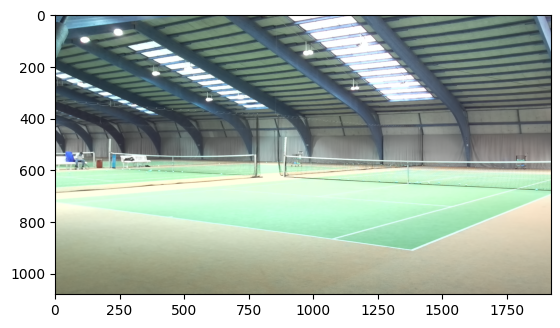

In [5]:
plt.imshow(median.cpu().numpy().astype(np.uint8))
plt.show()

In [6]:
frameFrom = 530
frameTo = 532

zed = sl.Camera()

# init parameters
init_params = sl.InitParameters()
init_params.set_from_svo_file(svo_path)
init_params.depth_mode = sl.DEPTH_MODE.ULTRA
init_params.coordinate_units = sl.UNIT.METER
init_params.depth_maximum_distance = 40
init_params.depth_minimum_distance = 1
init_params.sdk_verbose = True

zed.open(init_params)

SUCCESS

In [7]:


current_frame_left = sl.Mat()

# init detection parameters
detection_parameters = sl.ObjectDetectionParameters()

detection_parameters.image_sync = True
detection_parameters.enable_tracking = True
detection_parameters.enable_segmentation = True

detection_parameters.detection_model = sl.OBJECT_DETECTION_MODEL.MULTI_CLASS_BOX_MEDIUM

if detection_parameters.enable_tracking:
    zed.enable_positional_tracking()

zed.enable_object_detection(detection_parameters)

detection_confidence = 10
detection_parameters_rt = sl.ObjectDetectionRuntimeParameters(detection_confidence)

detection_parameters_rt.object_class_filter = [sl.OBJECT_CLASS.PERSON]

detected_objects = sl.Objects()
runtime_parameters = sl.RuntimeParameters()

last_ball_position_left = torch.tensor([0, 0]).to(device)
last_picture_left = torch.zeros((1080, 1920, 3)).to(device)


video = torch.zeros((1080, 1920, 3, frameTo - frameFrom))
zed.set_svo_position(frameFrom)

In [8]:

for frame in range(frameFrom, frameTo):
    if zed.grab(runtime_parameters) == sl.ERROR_CODE.SUCCESS:
        # Get Images
        zed.retrieve_image(current_frame_left, sl.VIEW.LEFT)
        zed.retrieve_objects(detected_objects, detection_parameters_rt)

        # Get Arrays
        current_frame_data_left = current_frame_left.get_data()[:, :, :3]
        

        # Get Moving Pixels
        moving_left = current_frame_data_left - median.cpu().numpy().astype(np.uint8)

        # Get Tennis Ball Positio
        if(frame == 530):
            last_picture_left = current_frame_data_left.copy()

    else:
        print(zed.grab(runtime_parameters))
        print('Error')

zed.close()

## Veränderung der Pixel

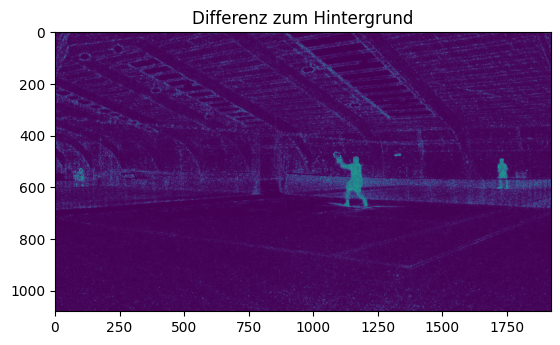

In [9]:
moving_pixels_relative_previous = current_frame_data_left - last_picture_left

diff_pixels_relative_previous = np.square(moving_pixels_relative_previous.astype(np.uint8)).sum(axis=2)
diff_pixels = np.square(moving_left.astype(np.uint8)).sum(axis=2)

plt.imshow(diff_pixels)
plt.title('Differenz zum Hintergrund')
plt.show()

Hier wird die Differenz der Pixel zum berechneten Hintergrund abgebildet. 

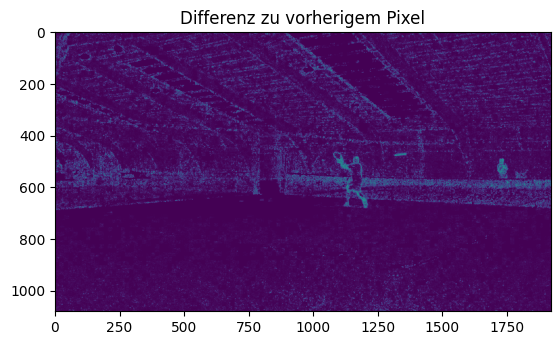

In [10]:
plt.imshow(diff_pixels_relative_previous)
plt.title('Differenz zu vorherigem Pixel')
plt.show()

Hier wird die Differenz der Pixel zum vorherigen Frame abgebildet. Es sind mehrheitlich Umrisse zu erkennen.

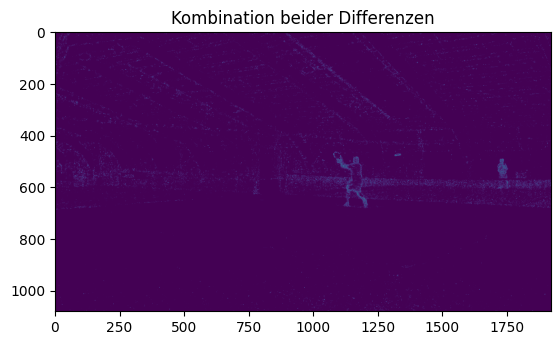

In [11]:
moving_pixels = diff_pixels_relative_previous * diff_pixels
plt.imshow(moving_pixels)
plt.title('Kombination beider Differenzen')
plt.show()

Durch die Multiplikation der beiden Differenzen werden die Veränderungen deutlicher. Enthält ein Pixel im Vergleich mit dem Hintergrund und mit dem vorherigen Frame eine Veränderung, so wird diese deutlicher.

## Area of Interest

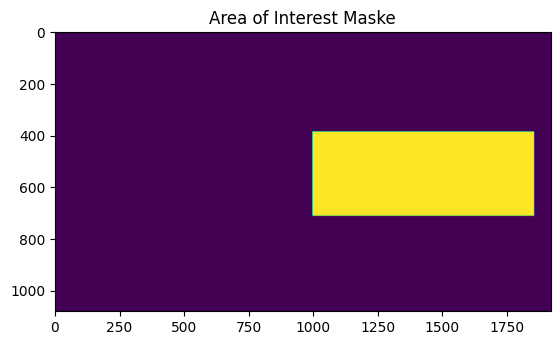

In [12]:
areaOfInterest = ballDetection.get_area_of_interest(torch.from_numpy(moving_pixels.astype(np.int8)).to(device), detected_objects).cpu().numpy().astype(np.int8)
plt.imshow(areaOfInterest)
plt.title('Area of Interest Maske')
plt.show()

Hier wird eine Maske erzeugt welche eine Box um alle erkannenten Personen legt. Liegt ein Pixel ausserhalb dieser Box, so wird er auf 0 gesetzt.

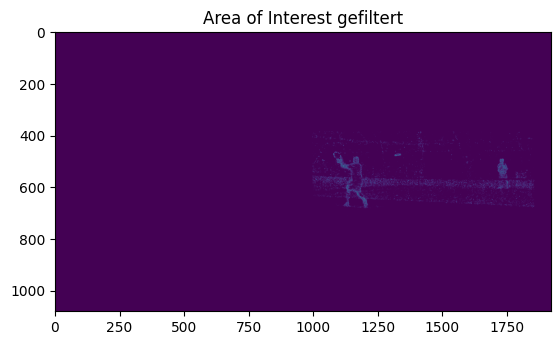

In [13]:
areaOfInterestImage = areaOfInterest * moving_pixels
plt.imshow(areaOfInterestImage)
plt.title('Area of Interest gefiltert')
plt.show()

Angewendet auf das aktuelle Bild.

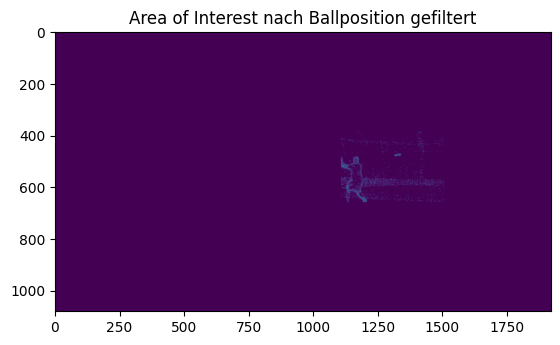

In [14]:
areaofBall = np.zeros_like(areaOfInterestImage)
last_ball_position = [460, 1305]
areaofBall[last_ball_position[0] - 200:last_ball_position[0] + 200, last_ball_position[1] - 200:last_ball_position[1] + 200] = 1
diff_pixels_dsa = (areaOfInterestImage * areaofBall)

plt.imshow(diff_pixels_dsa)
plt.title('Area of Interest nach Ballposition gefiltert')
plt.show()

Zusätzlich wird der Bereich noch auf den Bereich um den Ball eingegrenzt. Zur Wertung der Position des Balls wird die Position des Balls aus dem vorherigen Frame verwendet.

## Remove Objects

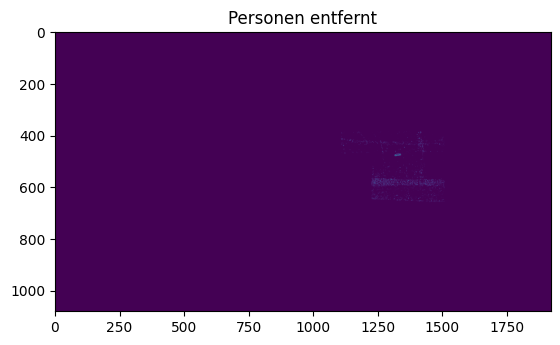

In [15]:
masked = diff_pixels_dsa.copy()
for i in range(len(detected_objects.object_list)):
    mask = ballDetection.get_mask(i, torch.from_numpy(diff_pixels_dsa).to(device), detected_objects, 15).to(device)
    mask = mask.cpu().numpy()
    masked[mask == 1.0] = 0.0

plt.imshow(masked)
plt.title('Personen entfernt')
plt.show()

Da wir die Position der Personen wissen, können wir diese aus dem Bild entfernen. Dazu wird eine Maske um die Person gelegt und diese auf 0 gesetzt.

## Gelbes Areal

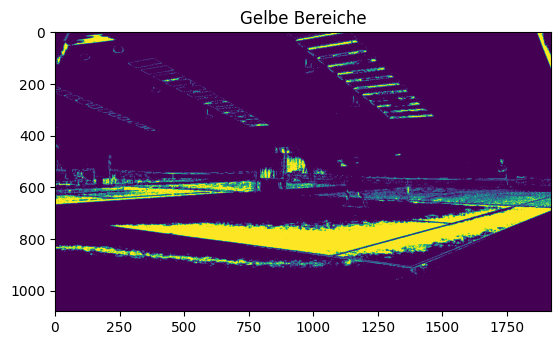

In [16]:
yellow = ballDetection.find_yellow_areas(torch.from_numpy(current_frame_data_left).to(device), device)
yellow = yellow.cpu().numpy()

plt.imshow(yellow)
plt.title('Gelbe Bereiche')
plt.show()

Auf dem Originalbild werden die gelben Bereiche markiert. Dafür habe ich ein Bereich des RGB Farbraums gewählt, welcher gelbe bis fast weisse Farben abdeckt.

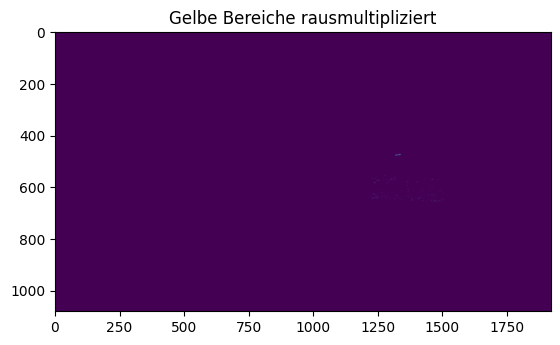

In [17]:
currentFrame = yellow * masked

plt.imshow(currentFrame)
plt.title('Gelbe Bereiche rausmultipliziert')
plt.show()

Die gelben Bereiche werden nun auf das Bild aufmultipliziert. Dadurch verschwinden Nicht-Gelbe Bereiche.

## Sliding Window

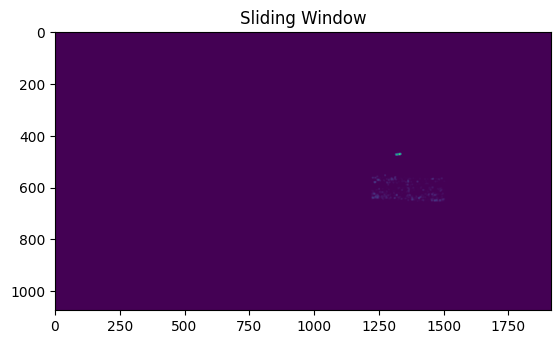

In [18]:
sliding = ballDetection.sliding_window(torch.from_numpy(currentFrame).to(device),(7,7))
sliding = sliding.cpu().numpy()

plt.imshow(sliding)
plt.title('Sliding Window')
plt.show()

Das Sliding Window wird angewendet. Es wird ein 7x7 Fenster über das Bild geschoben und der Durchschnitt der Pixel berechnet.

In [19]:
tensor_sliding = torch.from_numpy(sliding).to(device)
max_index = torch.argmax(tensor_sliding).to(device)
y_coord = max_index // tensor_sliding.shape[1]
x_coord = max_index % tensor_sliding.shape[1]

tensor_coordinates = torch.tensor([y_coord, x_coord]).to(device)

print(f'Coordinates: X: {x_coord}, Y: {y_coord}')

Coordinates: X: 1328, Y: 472


Die Position des Pixels mit dem höchsten Wert gilt als Position des Balls. 